In [1]:
# Import necessary library

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import json
import os
import yaml
import string
import copy
import hashlib

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from scipy.stats import kendalltau
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from datetime import datetime

In [2]:
def load_parameter(parameter_direction):
    with open(parameter_direction,'r') as file:
        params = yaml.safe_load(file)
    
    return params

In [3]:
params = load_parameter("config/configuration_file_1.yaml")

In [4]:
params

{'data_direction': 'data/indeks-standar-pencemar-udara-di-spku-bulan-juni-sampai-desember-tahun-2021_1.xlsx',
 'datetime_columns': ['tanggal'],
 'int32_columns': ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max'],
 'label': 'categori',
 'label_categories': ['BAIK', 'TIDAK SEHAT'],
 'object_columns': ['stasiun', 'critical', 'categori'],
 'predictors': ['stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2'],
 'range_co': [-1, 100],
 'range_no2': [-1, 100],
 'range_o3': [-1, 160],
 'range_pm10': [-1, 800],
 'range_pm25': [-1, 400],
 'range_so2': [-1, 500],
 'range_stasiun': ['DKI1 (Bunderan HI)',
  'DKI2 (Kelapa Gading)',
  'DKI3 (Jagakarsa)',
  'DKI4 (Lubang Buaya)',
  'DKI5 (Kebon Jeruk) Jakarta Barat']}

In [5]:
# Import dataset
dataset = pd.read_excel(params['data_direction'])

In [6]:
# Show dataset
dataset

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
0,2021-06-01,DKI1 (Bunderan HI),59,83,22,18,19,35,83,PM25,SEDANG
1,2021-06-02,DKI1 (Bunderan HI),59,84,21,20,24,38,84,PM25,SEDANG
2,2021-06-03,DKI1 (Bunderan HI),54,76,22,20,17,41,76,PM25,SEDANG
3,2021-06-04,DKI1 (Bunderan HI),63,87,20,13,14,30,87,PM25,SEDANG
4,2021-06-05,DKI1 (Bunderan HI),59,79,23,20,19,38,79,PM25,SEDANG
...,...,...,...,...,...,...,...,...,...,...,...
1065,2021-12-27,DKI5 (Kebon Jeruk) Jakarta Barat,54,76,36,14,21,47,76,PM25,SEDANG
1066,2021-12-28,DKI5 (Kebon Jeruk) Jakarta Barat,44,68,20,11,21,33,68,PM25,SEDANG
1067,2021-12-29,DKI5 (Kebon Jeruk) Jakarta Barat,34,54,28,8,25,29,54,PM25,SEDANG
1068,2021-12-30,DKI5 (Kebon Jeruk) Jakarta Barat,53,75,25,15,23,44,75,PM25,SEDANG


In [7]:
# Sanity check
dataset.shape

(1070, 11)

# Data Pipeline

In [8]:
# Check available column in dataframe
dataset.columns

Index(['tanggal', 'stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max',
       'critical', 'categori'],
      dtype='object')

In [9]:
# Check data type
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   1070 non-null   datetime64[ns]
 1   stasiun   1070 non-null   object        
 2   pm10      1070 non-null   object        
 3   pm25      1070 non-null   object        
 4   so2       1070 non-null   object        
 5   co        1070 non-null   object        
 6   o3        1070 non-null   object        
 7   no2       1070 non-null   object        
 8   max       1070 non-null   object        
 9   critical  1061 non-null   object        
 10  categori  1069 non-null   object        
dtypes: datetime64[ns](1), object(10)
memory usage: 92.1+ KB


**1. Data Validation**

In [10]:
def non_numerical_finder(data, columns):
    
    """
    This function is to locate a non numerical value within dataset. 
    
    :param data: <pandas dataframe> data contain sample
    :param column: <string> column name
    :return non_numerical: <list> list contain indexes
    """
    
    # Create blank list
    non_numerical = []
    
    # Loop to find non numerical column
    for col in columns:
        non_numeric = pd.to_numeric(data[col], errors = 'coerce').isna()
        non_numerical.extend(non_numeric[non_numeric == True].index.tolist())
    
    # Remove duplicates
    non_numerical = list(set(non_numerical))
    
    return non_numerical

In [11]:
# Find non numerical index
non_numerical = non_numerical_finder(dataset, params['int32_columns'])

In [12]:
# Show table which row or index have non numerical value
dataset.loc[non_numerical]

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
1025,2021-12-18,DKI4 (Lubang Buaya),---,69,42,13,24,17,69,PM25,SEDANG
515,2021-09-26,DKI2 (Kelapa Gading),56,74,---,7,54,6,74,PM25,SEDANG
1028,2021-12-21,DKI4 (Lubang Buaya),62,---,42,17,13,27,62,PM10,SEDANG
516,2021-09-27,DKI2 (Kelapa Gading),53,77,---,11,47,17,77,PM25,SEDANG
517,2021-09-28,DKI2 (Kelapa Gading),49,71,---,8,49,13,71,PM25,SEDANG
...,...,...,...,...,...,...,...,...,...,...,...
993,2021-12-17,DKI3 (Jagakarsa),39,59,43,13,---,16,59,PM25,SEDANG
1004,2021-12-28,DKI3 (Jagakarsa),51,74,---,13,17,18,74,PM25,SEDANG
1007,2021-12-31,DKI3 (Jagakarsa),64,52,21,44,17,---,64,PM10,SEDANG
1019,2021-12-12,DKI4 (Lubang Buaya),---,---,---,---,---,---,0,NaN,TIDAK ADA DATA


In [13]:
# Replace value function
def replace_value(data, column, column_number, old_value, replace_value):
    
    """
    This function is to locate and replace value from a column. 
    
    :param data: <pandas dataframe> data contain sample
    :param column: <string> column name
    :param column_number: <string> single or multiple column
    :param old_value: <string/int/float> old value or current value
    :param replace_value: <string/int/float> value to replace old value
    :return data: <pandas dataframe> data contain sample
    """
    
    if str(column_number).lower() == "multiple":
        for col in column:
            data[col] = data[col].replace(old_value, replace_value)
    elif str(column_number).lower() == "single":
        data[column] = data[column].replace(old_value, replace_value)
        
    else: 
        "column_number is not correct"
        
    return data

In [14]:
# Handling non numeric data
replace_value(data = dataset, 
              column = params['int32_columns'],
              column_number = "multiple",
              old_value = "---", 
              replace_value = -1)

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
0,2021-06-01,DKI1 (Bunderan HI),59,83,22,18,19,35,83,PM25,SEDANG
1,2021-06-02,DKI1 (Bunderan HI),59,84,21,20,24,38,84,PM25,SEDANG
2,2021-06-03,DKI1 (Bunderan HI),54,76,22,20,17,41,76,PM25,SEDANG
3,2021-06-04,DKI1 (Bunderan HI),63,87,20,13,14,30,87,PM25,SEDANG
4,2021-06-05,DKI1 (Bunderan HI),59,79,23,20,19,38,79,PM25,SEDANG
...,...,...,...,...,...,...,...,...,...,...,...
1065,2021-12-27,DKI5 (Kebon Jeruk) Jakarta Barat,54,76,36,14,21,47,76,PM25,SEDANG
1066,2021-12-28,DKI5 (Kebon Jeruk) Jakarta Barat,44,68,20,11,21,33,68,PM25,SEDANG
1067,2021-12-29,DKI5 (Kebon Jeruk) Jakarta Barat,34,54,28,8,25,29,54,PM25,SEDANG
1068,2021-12-30,DKI5 (Kebon Jeruk) Jakarta Barat,53,75,25,15,23,44,75,PM25,SEDANG


In [15]:
# Show table which row or index have non numerical value
dataset.loc[non_numerical]

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
1025,2021-12-18,DKI4 (Lubang Buaya),-1,69,42,13,24,17,69,PM25,SEDANG
515,2021-09-26,DKI2 (Kelapa Gading),56,74,-1,7,54,6,74,PM25,SEDANG
1028,2021-12-21,DKI4 (Lubang Buaya),62,-1,42,17,13,27,62,PM10,SEDANG
516,2021-09-27,DKI2 (Kelapa Gading),53,77,-1,11,47,17,77,PM25,SEDANG
517,2021-09-28,DKI2 (Kelapa Gading),49,71,-1,8,49,13,71,PM25,SEDANG
...,...,...,...,...,...,...,...,...,...,...,...
993,2021-12-17,DKI3 (Jagakarsa),39,59,43,13,-1,16,59,PM25,SEDANG
1004,2021-12-28,DKI3 (Jagakarsa),51,74,-1,13,17,18,74,PM25,SEDANG
1007,2021-12-31,DKI3 (Jagakarsa),64,52,21,44,17,-1,64,PM10,SEDANG
1019,2021-12-12,DKI4 (Lubang Buaya),-1,-1,-1,-1,-1,-1,0,NaN,TIDAK ADA DATA


In [16]:
# Find non numerical index
non_numerical_new = non_numerical_finder(dataset, params['int32_columns'])
non_numerical_new

[917]

In [17]:
# Creating function to replace value to a specific row and cell
def replace_specific_index(data, index, column, new_value):
    
    """
    This function is created to replace a new value to old value located in specific index and column
    :param data: <pandas dataframe> data contain sample
    :param index: <int> specific index
    :param column: <string> specific column
    :param new_value: <string/int/float> new value to replace old value
    :return dataset: <pandas dataframe> data contain sample
    """
    data.loc[index, column] = new_value
    
    return data

In [18]:
# Replace value
replace_specific_index(data = dataset, index = non_numerical_new[0], column = 'max', new_value = 49)
replace_specific_index(data = dataset, index = non_numerical_new[0], column = 'critical', new_value = 'PM10')
replace_specific_index(data = dataset, index = non_numerical_new[0], column = 'categori', new_value = 'BAIK')

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
0,2021-06-01,DKI1 (Bunderan HI),59,83,22,18,19,35,83,PM25,SEDANG
1,2021-06-02,DKI1 (Bunderan HI),59,84,21,20,24,38,84,PM25,SEDANG
2,2021-06-03,DKI1 (Bunderan HI),54,76,22,20,17,41,76,PM25,SEDANG
3,2021-06-04,DKI1 (Bunderan HI),63,87,20,13,14,30,87,PM25,SEDANG
4,2021-06-05,DKI1 (Bunderan HI),59,79,23,20,19,38,79,PM25,SEDANG
...,...,...,...,...,...,...,...,...,...,...,...
1065,2021-12-27,DKI5 (Kebon Jeruk) Jakarta Barat,54,76,36,14,21,47,76,PM25,SEDANG
1066,2021-12-28,DKI5 (Kebon Jeruk) Jakarta Barat,44,68,20,11,21,33,68,PM25,SEDANG
1067,2021-12-29,DKI5 (Kebon Jeruk) Jakarta Barat,34,54,28,8,25,29,54,PM25,SEDANG
1068,2021-12-30,DKI5 (Kebon Jeruk) Jakarta Barat,53,75,25,15,23,44,75,PM25,SEDANG


In [19]:
# Handling non numeric for pm10, pm25, so2, co, o3, no2
def change_data_type(data, column, data_type):
    
    """
    This function is to change the type of a specific column into a desired type.
    
    :param data: <pandas dataframe> data contain sample
    :param column: <string> column name
    :param data_type: <string> desired data type
    :return dataset: <pandas dataframe> data contain sample
    """
    
    for col in column:
        data[col] = data[col].astype(data_type)
    
    return data

In [20]:
# Change column type
change_data_type(data = dataset, column = params['int32_columns'], data_type = int)

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
0,2021-06-01,DKI1 (Bunderan HI),59,83,22,18,19,35,83,PM25,SEDANG
1,2021-06-02,DKI1 (Bunderan HI),59,84,21,20,24,38,84,PM25,SEDANG
2,2021-06-03,DKI1 (Bunderan HI),54,76,22,20,17,41,76,PM25,SEDANG
3,2021-06-04,DKI1 (Bunderan HI),63,87,20,13,14,30,87,PM25,SEDANG
4,2021-06-05,DKI1 (Bunderan HI),59,79,23,20,19,38,79,PM25,SEDANG
...,...,...,...,...,...,...,...,...,...,...,...
1065,2021-12-27,DKI5 (Kebon Jeruk) Jakarta Barat,54,76,36,14,21,47,76,PM25,SEDANG
1066,2021-12-28,DKI5 (Kebon Jeruk) Jakarta Barat,44,68,20,11,21,33,68,PM25,SEDANG
1067,2021-12-29,DKI5 (Kebon Jeruk) Jakarta Barat,34,54,28,8,25,29,54,PM25,SEDANG
1068,2021-12-30,DKI5 (Kebon Jeruk) Jakarta Barat,53,75,25,15,23,44,75,PM25,SEDANG


In [21]:
# Sanity check
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   1070 non-null   datetime64[ns]
 1   stasiun   1070 non-null   object        
 2   pm10      1070 non-null   int32         
 3   pm25      1070 non-null   int32         
 4   so2       1070 non-null   int32         
 5   co        1070 non-null   int32         
 6   o3        1070 non-null   int32         
 7   no2       1070 non-null   int32         
 8   max       1070 non-null   int32         
 9   critical  1061 non-null   object        
 10  categori  1070 non-null   object        
dtypes: datetime64[ns](1), int32(7), object(3)
memory usage: 62.8+ KB


In [22]:
# Categori proportion
dataset[params['label']].value_counts()

SEDANG            791
TIDAK SEHAT       207
BAIK               63
TIDAK ADA DATA      9
Name: categori, dtype: int64

In [23]:
# Handling irrelevant data
dataset.drop(index = dataset[dataset[params['label']] == "TIDAK ADA DATA"].index, inplace = True)

In [24]:
# Categori proportion
dataset[params['label']].value_counts()

SEDANG         791
TIDAK SEHAT    207
BAIK            63
Name: categori, dtype: int64

In [25]:
# Sanity check
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1061 entries, 0 to 1069
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   1061 non-null   datetime64[ns]
 1   stasiun   1061 non-null   object        
 2   pm10      1061 non-null   int32         
 3   pm25      1061 non-null   int32         
 4   so2       1061 non-null   int32         
 5   co        1061 non-null   int32         
 6   o3        1061 non-null   int32         
 7   no2       1061 non-null   int32         
 8   max       1061 non-null   int32         
 9   critical  1061 non-null   object        
 10  categori  1061 non-null   object        
dtypes: datetime64[ns](1), int32(7), object(3)
memory usage: 70.5+ KB


**2. Data Defense**

In [26]:
def check_data(input_data, params):
    # check data types
    assert input_data.select_dtypes("datetime").columns.to_list() == params["datetime_columns"], "an error occurs in datetime column(s)."
    assert input_data.select_dtypes("object").columns.to_list() == params["object_columns"], "an error occurs in object column(s)."
    assert input_data.select_dtypes("int").columns.to_list() == params["int32_columns"], "an error occurs in int32 column(s)."

    # check range of data
    assert set(input_data.stasiun).issubset(set(params["range_stasiun"])), "an error occurs in stasiun range."
    assert input_data['pm10'].between(params["range_pm10"][0], params["range_pm10"][1]).sum() == len(input_data), "an error occurs in pm10 column."
    assert input_data['pm25'].between(params["range_pm25"][0], params["range_pm25"][1]).sum() == len(input_data), "an error occurs in pm25 column."
    assert input_data['so2'].between(params["range_so2"][0], params["range_so2"][1]).sum() == len(input_data), "an error occurs in so2 column."
    assert input_data['co'].between(params["range_co"][0], params["range_co"][1]).sum() == len(input_data), "an error occurs in co column."
    assert input_data['o3'].between(params["range_o3"][0], params["range_o3"][1]).sum() == len(input_data), "an error occurs in o3 column."
    assert input_data['no2'].between(params["range_no2"][0], params["range_no2"][1]).sum() == len(input_data), "an error occurs in no2 column."

In [27]:
# Check data
check_data(dataset, params)

**3. Data Splitting**

In [28]:
# Input-Output split function
def input_output_split(df, column):
    
    """
    This function is created to split input and output column
    :param df: <pandas dataframe> data contain sample
    :param columns: <string> column name
    :return X: <pandas dataframe> data contain input
    :return y: <pandas dataframe> data contain output
    """
    
    X = df.drop(column, axis = 1)
    y = df[column]
    
    return X,y

In [29]:
X, y = input_output_split(df = dataset, column = params['label'])

In [30]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.35,
                                                    stratify = y,
                                                    random_state = 123)

In [31]:
# Train-Test split
X_valid, X_test, y_valid, y_test = train_test_split(X_test,
                                                    y_test,
                                                    test_size = 0.5,
                                                    stratify = y_test,
                                                    random_state = 123)

# Exploratory Data Analysis

**1. Identify Missing Value**

In [32]:
# Store into variable
EDA_dataset_missing_value = pd.concat([X_train, y_train], axis = 1)

In [33]:
# Checking replaced value
for col in params['int32_columns']:
    print(len(EDA_dataset_missing_value[EDA_dataset_missing_value[col] == -1]))

15
13
56
2
15
1
0


In [34]:
# Replace value
EDA_dataset_missing_value = replace_value(data = EDA_dataset_missing_value, 
                                          column = params['int32_columns'],
                                          column_number = "multiple",
                                          old_value = -1, 
                                          replace_value = np.nan)

In [35]:
# Sanity check
EDA_dataset_missing_value.isna().sum()

tanggal      0
stasiun      0
pm10        15
pm25        13
so2         56
co           2
o3          15
no2          1
max          0
critical     0
categori     0
dtype: int64

**2. Identify skewness**

In [36]:
# Store into variable
EDA_dataset_skewness = EDA_dataset_missing_value

In [37]:
# Check skewness
EDA_dataset_skewness.skew(numeric_only = True)

pm10    0.676402
pm25    0.282551
so2    -0.076043
co      0.701355
o3      1.042900
no2     0.935780
max     0.543511
dtype: float64

- pm10 = skewness dari pm10 cukup signifikan sehingga menggunakan median
- pm25 = skewness dari pm25 tidak terlalu signifikan sehingga menggunakan mean
- so2 = skewness dari so2 tidak terlalu signifikan sehingga menggunakan mean
- co = skewness dari co cukup signifikan sehingga menggunakan median
- o3 = skewness dari o3 cukup signifikan sehingga menggunakan median
- no2 = skewness dari no2 cukup signifikan sehingga menggunakan median

In [38]:
# Split dataset
EDA_dataset_baik = EDA_dataset_skewness[EDA_dataset_skewness[params['label']] == params['label_categories'][0]]
EDA_dataset_tidak_baik = EDA_dataset_skewness[EDA_dataset_skewness[params['label']] != params['label_categories'][0]]

In [39]:
# Descriptive analysis
EDA_dataset_baik.describe()

,pm10,pm25,so2,co,o3,no2,max
count,40.000000,33.000000,37.000000,41.000000,40.000000,40.000000,41.000000
mean,28.150000,40.363636,27.729730,6.902439,24.450000,10.475000,42.487805
std,7.761014,6.990253,14.062655,4.352039,12.469347,5.193623,5.630817
min,15.000000,27.000000,4.000000,2.000000,8.000000,4.000000,30.000000
25%,23.000000,35.000000,15.000000,3.000000,14.000000,6.000000,38.000000
50%,28.000000,41.000000,31.000000,7.000000,18.000000,10.000000,44.000000
75%,31.250000,46.000000,36.000000,8.000000,37.000000,13.000000,47.000000
max,50.000000,50.000000,50.000000,28.000000,48.000000,29.000000,50.000000


In [40]:
# Descriptive analysis
EDA_dataset_tidak_baik.describe()

,pm10,pm25,so2,co,o3,no2,max
count,634.000000,643.000000,596.000000,646.000000,634.000000,648.000000,648.000000
mean,57.613565,85.129082,39.827181,11.662539,31.249211,22.270062,85.640432
std,12.549700,21.390534,11.579989,4.014013,12.550475,8.987690,20.792536
min,23.000000,26.000000,5.000000,3.000000,9.000000,6.000000,51.000000
25%,51.000000,71.000000,31.000000,9.000000,23.000000,15.000000,71.000000
50%,57.500000,83.000000,40.000000,11.000000,28.500000,21.000000,83.000000
75%,64.000000,98.000000,49.000000,14.000000,36.000000,27.000000,98.000000
max,179.000000,174.000000,82.000000,28.000000,77.000000,65.000000,179.000000


- pm10      : median dari kelas 0 dan 1 terpaut cukup jauh, maka akan menggunakan kelas
- pm25      : mean dari kelas 0 dan 1 terpaut cukup jauh, maka akan menggunakan kelas
- so2       : mean dari kelas 0 dan 1 tidak terpaut cukup jauh, maka tidak akan menggunakan kelas
- co        : median dari kelas 0 dan 1 tidak terpaut jauh, maka tidak akan menggunakan kelas
- o3        : median dari kelas 0 dan 1 tidak terpaut cukup jauh, maka tidak akan menggunakan kelas
- no2       : median dari kelas 0 dan 1 tidak terpaut cukup jauh, maka tidak akan menggunakan kelas

**3. Check outliers**

In [41]:
EDA_dataset_outliers = EDA_dataset_skewness

<AxesSubplot:>

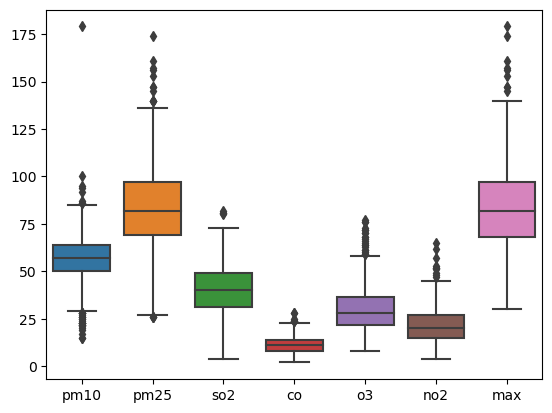

In [42]:
# Checking outliers using boxplot
sns.boxplot(data=EDA_dataset_outliers[params['int32_columns']])

**4. Identify correlation**

In [43]:
# Store into variable
EDA_dataset_correlation = pd.concat([X_train, y_train], axis = 1)

In [44]:
# Split input and output
EDA_X_train, EDA_y_train = input_output_split(df = EDA_dataset_correlation, column = params['label'])

# EDA_X_train_baik, EDA_y_train_baik = input_output_split(df = EDA_dataset_correlation[EDA_dataset_correlation[params['label']] == "BAIK"], column = params['label'])
# EDA_X_train_tidak_baik, EDA_y_train_tidak_baik = input_output_split(df = EDA_dataset_correlation[EDA_dataset_correlation[params['label']] != "BAIK"], column = params['label'])

# Sanity check
# print(f"{EDA_X_train.shape}, {EDA_y_train.shape} \n{EDA_X_train_baik.shape},  {EDA_y_train_baik.shape} \n{EDA_X_train_tidak_baik.shape}, {EDA_y_train_tidak_baik.shape}")

In [45]:
# Create Kendall's rank coefficient and p-value calculation function
def kendall_rank(input, output):
    
    """
    This function is created to calculate the level of significance between numeric type input data and object type output data 
    using kendall's rank
    
    :param input: <pandas dataframe> data contain input
    :param output: <pandas dataframe> data contain output  
    :return kendall_rank: <dictionary> collection of coefficient and p_value
    """
    
    # Create an empty dictionary to store the results
    kendall_rank = {}
    
    # Loop over each column in the numerical data DataFrame
    for col in input.columns:
        
        # Calculate Kendall's rank correlation coefficient    
        coefficient, p_value = kendalltau(input[col], output)
        
        # Store the results in the dictionary
        kendall_rank[col] = (coefficient, p_value)
    
    return kendall_rank

In [46]:
# Show Kendall's rank coefficient and p-value
kendall_rank(input = EDA_X_train[params['int32_columns']], output = EDA_y_train)

C:\Users\62821\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


{'pm10': (0.517006500771629, 3.85078834072556e-63),
 'pm25': (0.6261809717253971, 1.1651321446359456e-92),
 'so2': (0.15520803201682432, 5.08643843557653e-07),
 'co': (0.2090500630578317, 3.432774947417078e-11),
 'o3': (0.11112003220819085, 0.00031715865932951444),
 'no2': (0.2476701887225367, 1.2826565919262394e-15),
 'max': (0.6387247124208845, 2.5771840362539116e-96)}

No need to reducing feature since all of them have significant p-value but this will need to be re-check once the missing value has been handled.

**5. Check data proportion**

<AxesSubplot:xlabel='categori', ylabel='Count'>

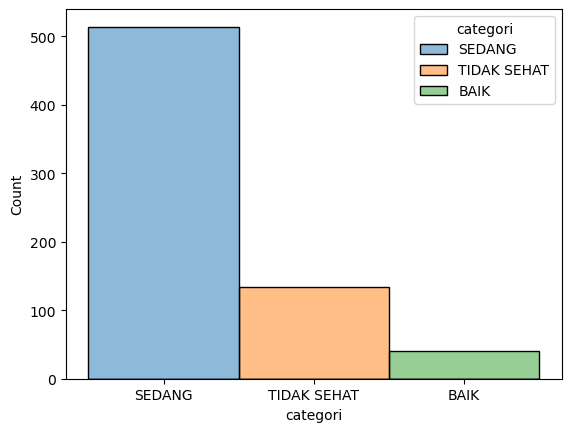

In [47]:
# Check data proportion
sns.histplot(data = pd.concat([X_train, y_train], axis = 1), x = params['label'], hue = params['label'])

# Data Pre-processing

In [48]:
# Combining data
train_set = pd.concat([X_train, y_train], axis = 1)
validation_set = pd.concat([X_valid, y_valid], axis = 1)
testing_set = pd.concat([X_test, y_test], axis = 1)

**1. Recategorised label**

Train set

In [49]:
# Check data proportion
train_set[params['label']].value_counts()

SEDANG         514
TIDAK SEHAT    134
BAIK            41
Name: categori, dtype: int64

In [50]:
# Replace value
replace_value(train_set, params['label'], 'single', 'SEDANG', "TIDAK SEHAT")

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
499,2021-09-10,DKI2 (Kelapa Gading),58,77,53,9,32,20,77,PM25,TIDAK SEHAT
472,2021-09-13,DKI1 (Bunderan HI),51,64,29,8,23,21,64,PM25,TIDAK SEHAT
857,2021-11-03,DKI4 (Lubang Buaya),51,83,42,12,73,17,83,PM25,TIDAK SEHAT
79,2021-06-20,DKI3 (Jagakarsa),80,111,52,7,24,29,111,PM25,TIDAK SEHAT
545,2021-09-26,DKI3 (Jagakarsa),54,74,50,10,27,13,74,PM25,TIDAK SEHAT
...,...,...,...,...,...,...,...,...,...,...,...
452,2021-08-24,DKI5 (Kebon Jeruk) Jakarta Barat,60,97,31,7,32,12,97,PM25,TIDAK SEHAT
556,2021-09-07,DKI4 (Lubang Buaya),56,86,42,8,21,21,86,PM25,TIDAK SEHAT
162,2021-07-13,DKI1 (Bunderan HI),63,89,33,10,18,24,89,PM25,TIDAK SEHAT
439,2021-08-11,DKI5 (Kebon Jeruk) Jakarta Barat,54,92,29,11,25,25,92,PM25,TIDAK SEHAT


In [51]:
# Check data proportion
train_set[params['label']].value_counts()

TIDAK SEHAT    648
BAIK            41
Name: categori, dtype: int64

Valid set

In [52]:
# Check data proportion
validation_set[params['label']].value_counts()

SEDANG         138
TIDAK SEHAT     37
BAIK            11
Name: categori, dtype: int64

In [53]:
# Replace value
replace_value(validation_set, params['label'], 'single', 'SEDANG', "TIDAK SEHAT")

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
967,2021-12-22,DKI2 (Kelapa Gading),65,94,36,21,54,49,94,PM25,TIDAK SEHAT
408,2021-08-11,DKI4 (Lubang Buaya),56,102,39,11,27,23,102,PM25,TIDAK SEHAT
789,2021-11-25,DKI1 (Bunderan HI),39,57,34,10,11,7,57,PM25,TIDAK SEHAT
604,2021-09-25,DKI5 (Kebon Jeruk) Jakarta Barat,45,64,-1,4,24,12,64,PM25,TIDAK SEHAT
921,2021-12-07,DKI1 (Bunderan HI),30,31,34,12,16,9,34,SO2,BAIK
...,...,...,...,...,...,...,...,...,...,...,...
65,2021-06-06,DKI3 (Jagakarsa),63,95,45,11,26,19,95,PM25,TIDAK SEHAT
1028,2021-12-21,DKI4 (Lubang Buaya),62,-1,42,17,13,27,62,PM10,TIDAK SEHAT
844,2021-11-20,DKI3 (Jagakarsa),37,53,43,6,31,8,53,PM25,TIDAK SEHAT
453,2021-08-25,DKI5 (Kebon Jeruk) Jakarta Barat,63,95,31,10,29,20,95,PM25,TIDAK SEHAT


In [54]:
# Check data proportion
validation_set[params['label']].value_counts()

TIDAK SEHAT    175
BAIK            11
Name: categori, dtype: int64

Test set

In [55]:
# Check data proportion
testing_set[params['label']].value_counts()

SEDANG         139
TIDAK SEHAT     36
BAIK            11
Name: categori, dtype: int64

In [56]:
# Replace value
replace_value(testing_set, params['label'], 'single', 'SEDANG', "TIDAK SEHAT")

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
168,2021-07-19,DKI1 (Bunderan HI),66,95,26,10,32,28,95,PM25,TIDAK SEHAT
622,2021-10-13,DKI1 (Bunderan HI),52,67,28,8,25,31,67,PM25,TIDAK SEHAT
621,2021-10-12,DKI1 (Bunderan HI),56,76,37,9,23,35,76,PM25,TIDAK SEHAT
176,2021-07-27,DKI1 (Bunderan HI),61,91,29,10,23,28,91,PM25,TIDAK SEHAT
668,2021-10-28,DKI2 (Kelapa Gading),51,70,67,12,49,30,70,PM25,TIDAK SEHAT
...,...,...,...,...,...,...,...,...,...,...,...
420,2021-08-23,DKI4 (Lubang Buaya),63,106,40,10,24,20,106,PM25,TIDAK SEHAT
697,2021-10-26,DKI3 (Jagakarsa),51,71,51,13,30,15,71,PM25,TIDAK SEHAT
480,2021-09-21,DKI1 (Bunderan HI),55,81,28,11,29,36,81,PM25,TIDAK SEHAT
12,2021-06-13,DKI1 (Bunderan HI),51,70,23,14,25,25,70,PM25,TIDAK SEHAT


In [57]:
# Check data proportion
testing_set[params['label']].value_counts()

TIDAK SEHAT    175
BAIK            11
Name: categori, dtype: int64

**2. Handling missing value**

In [58]:
# Checking replaced value
for col in params['int32_columns']:
    print(len(train_set[train_set[col] == -1]))

15
13
56
2
15
1
0


In [59]:
# Replace value
replace_value(data = train_set, 
              column = train_set.columns,
              column_number = "multiple",
              old_value = -1,
              replace_value = np.nan)

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
499,2021-09-10,DKI2 (Kelapa Gading),58.0,77.0,53.0,9.0,32.0,20.0,77,PM25,TIDAK SEHAT
472,2021-09-13,DKI1 (Bunderan HI),51.0,64.0,29.0,8.0,23.0,21.0,64,PM25,TIDAK SEHAT
857,2021-11-03,DKI4 (Lubang Buaya),51.0,83.0,42.0,12.0,73.0,17.0,83,PM25,TIDAK SEHAT
79,2021-06-20,DKI3 (Jagakarsa),80.0,111.0,52.0,7.0,24.0,29.0,111,PM25,TIDAK SEHAT
545,2021-09-26,DKI3 (Jagakarsa),54.0,74.0,50.0,10.0,27.0,13.0,74,PM25,TIDAK SEHAT
...,...,...,...,...,...,...,...,...,...,...,...
452,2021-08-24,DKI5 (Kebon Jeruk) Jakarta Barat,60.0,97.0,31.0,7.0,32.0,12.0,97,PM25,TIDAK SEHAT
556,2021-09-07,DKI4 (Lubang Buaya),56.0,86.0,42.0,8.0,21.0,21.0,86,PM25,TIDAK SEHAT
162,2021-07-13,DKI1 (Bunderan HI),63.0,89.0,33.0,10.0,18.0,24.0,89,PM25,TIDAK SEHAT
439,2021-08-11,DKI5 (Kebon Jeruk) Jakarta Barat,54.0,92.0,29.0,11.0,25.0,25.0,92,PM25,TIDAK SEHAT


In [60]:
# Sanity check
train_set.isna().sum()

tanggal      0
stasiun      0
pm10        15
pm25        13
so2         56
co           2
o3          15
no2          1
max          0
critical     0
categori     0
dtype: int64

In [61]:
# Checking replaced value
for col in params['int32_columns']:
    print(len(validation_set[validation_set[col] == -1]))

4
4
17
3
7
3
0


In [62]:
# Replace value
replace_value(data = validation_set, 
              column = validation_set.columns,
              column_number = "multiple",
              old_value = -1,
              replace_value = np.nan)

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
967,2021-12-22,DKI2 (Kelapa Gading),65.0,94.0,36.0,21.0,54.0,49.0,94,PM25,TIDAK SEHAT
408,2021-08-11,DKI4 (Lubang Buaya),56.0,102.0,39.0,11.0,27.0,23.0,102,PM25,TIDAK SEHAT
789,2021-11-25,DKI1 (Bunderan HI),39.0,57.0,34.0,10.0,11.0,7.0,57,PM25,TIDAK SEHAT
604,2021-09-25,DKI5 (Kebon Jeruk) Jakarta Barat,45.0,64.0,NaN,4.0,24.0,12.0,64,PM25,TIDAK SEHAT
921,2021-12-07,DKI1 (Bunderan HI),30.0,31.0,34.0,12.0,16.0,9.0,34,SO2,BAIK
...,...,...,...,...,...,...,...,...,...,...,...
65,2021-06-06,DKI3 (Jagakarsa),63.0,95.0,45.0,11.0,26.0,19.0,95,PM25,TIDAK SEHAT
1028,2021-12-21,DKI4 (Lubang Buaya),62.0,NaN,42.0,17.0,13.0,27.0,62,PM10,TIDAK SEHAT
844,2021-11-20,DKI3 (Jagakarsa),37.0,53.0,43.0,6.0,31.0,8.0,53,PM25,TIDAK SEHAT
453,2021-08-25,DKI5 (Kebon Jeruk) Jakarta Barat,63.0,95.0,31.0,10.0,29.0,20.0,95,PM25,TIDAK SEHAT


In [63]:
# Sanity check
validation_set.isna().sum()

tanggal      0
stasiun      0
pm10         4
pm25         4
so2         17
co           3
o3           7
no2          3
max          0
critical     0
categori     0
dtype: int64

In [64]:
# Checking replaced value
for col in params['int32_columns']:
    print(len(testing_set[testing_set[col] == -1]))

6
3
15
2
6
1
0


In [65]:
# Replace value
replace_value(data = testing_set, 
              column = testing_set.columns,
              column_number = "multiple",
              old_value = -1,
              replace_value = np.nan)

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
168,2021-07-19,DKI1 (Bunderan HI),66.0,95.0,26.0,10.0,32.0,28.0,95,PM25,TIDAK SEHAT
622,2021-10-13,DKI1 (Bunderan HI),52.0,67.0,28.0,8.0,25.0,31.0,67,PM25,TIDAK SEHAT
621,2021-10-12,DKI1 (Bunderan HI),56.0,76.0,37.0,9.0,23.0,35.0,76,PM25,TIDAK SEHAT
176,2021-07-27,DKI1 (Bunderan HI),61.0,91.0,29.0,10.0,23.0,28.0,91,PM25,TIDAK SEHAT
668,2021-10-28,DKI2 (Kelapa Gading),51.0,70.0,67.0,12.0,49.0,30.0,70,PM25,TIDAK SEHAT
...,...,...,...,...,...,...,...,...,...,...,...
420,2021-08-23,DKI4 (Lubang Buaya),63.0,106.0,40.0,10.0,24.0,20.0,106,PM25,TIDAK SEHAT
697,2021-10-26,DKI3 (Jagakarsa),51.0,71.0,51.0,13.0,30.0,15.0,71,PM25,TIDAK SEHAT
480,2021-09-21,DKI1 (Bunderan HI),55.0,81.0,28.0,11.0,29.0,36.0,81,PM25,TIDAK SEHAT
12,2021-06-13,DKI1 (Bunderan HI),51.0,70.0,23.0,14.0,25.0,25.0,70,PM25,TIDAK SEHAT


In [66]:
# Sanity check
testing_set.isna().sum()

tanggal      0
stasiun      0
pm10         6
pm25         3
so2         15
co           2
o3           6
no2          1
max          0
critical     0
categori     0
dtype: int64

- pm10      : median dari kelas 0 dan 1 terpaut cukup jauh, maka akan menggunakan kelas

In [67]:
# Calculate median
imputation_baik = int(train_set[train_set[params['label']] == params['label_categories'][0]].pm10.median())
imputation_tidak_sehat = int(train_set[train_set[params['label']] == params['label_categories'][1]].pm10.median())

In [68]:
# Show mean
imputation_baik, imputation_tidak_sehat

(28, 57)

1. Train set

In [69]:
# Checking mising value proportion
train_set[train_set[params['label']] == params['label_categories'][0]].pm10.isnull().sum(), train_set[train_set[params['label']] == params['label_categories'][1]].pm10.isnull().sum()

(1, 14)

In [70]:
# Missing value imputation
train_set.loc[train_set[(train_set[params['label']] == params['label_categories'][0]) & (train_set['pm10'].isnull() == True)].index, "pm10"] = imputation_baik
train_set.loc[train_set[(train_set[params['label']] == params['label_categories'][1]) & (train_set['pm10'].isnull() == True)].index, "pm10"] = imputation_tidak_sehat

In [71]:
# Checking mising value proportion
train_set[train_set[params['label']] == params['label_categories'][0]].pm10.isnull().sum(), train_set[train_set[params['label']] == params['label_categories'][1]].pm10.isnull().sum()

(0, 0)

2. Validation set

In [72]:
# Checking mising value proportion
validation_set[validation_set[params['label']] == params['label_categories'][0]].pm10.isnull().sum(), validation_set[validation_set[params['label']] == params['label_categories'][1]].pm10.isnull().sum()

(0, 4)

In [73]:
# Missing value imputation
validation_set.loc[validation_set[(validation_set[params['label']] == params['label_categories'][0]) & (validation_set['pm10'].isnull() == True)].index, "pm10"] = imputation_baik
validation_set.loc[validation_set[(validation_set[params['label']] == params['label_categories'][1]) & (validation_set['pm10'].isnull() == True)].index, "pm10"] = imputation_tidak_sehat

In [74]:
# Checking mising value proportion
validation_set[validation_set[params['label']] == params['label_categories'][0]].pm10.isnull().sum(), validation_set[validation_set[params['label']] == params['label_categories'][1]].pm10.isnull().sum()

(0, 0)

3. Test set

In [75]:
# Checking mising value proportion
testing_set[testing_set[params['label']] == params['label_categories'][0]].pm10.isnull().sum(), testing_set[testing_set[params['label']] == params['label_categories'][1]].pm10.isnull().sum()

(0, 6)

In [76]:
# Missing value imputation
testing_set.loc[testing_set[(testing_set[params['label']] == params['label_categories'][0]) & (testing_set['pm10'].isnull() == True)].index, "pm10"] = imputation_baik
testing_set.loc[testing_set[(testing_set[params['label']] == params['label_categories'][1]) & (testing_set['pm10'].isnull() == True)].index, "pm10"] = imputation_tidak_sehat

In [77]:
# Checking mising value proportion
testing_set[testing_set[params['label']] == params['label_categories'][0]].pm10.isnull().sum(), testing_set[testing_set[params['label']] == params['label_categories'][1]].pm10.isnull().sum()

(0, 0)

- pm25      : mean dari kelas 0 dan 1 terpaut cukup jauh, maka akan menggunakan kelas

In [78]:
# Calculate mean
imputation_baik = int(train_set[train_set[params['label']] == params['label_categories'][0]].pm25.mean())
imputation_tidak_sehat = int(train_set[train_set[params['label']] == params['label_categories'][1]].pm25.mean())

In [79]:
# Show mean
imputation_baik, imputation_tidak_sehat

(40, 85)

1. Train set

In [80]:
# Checking mising value proportion
train_set[train_set[params['label']] == params['label_categories'][0]].pm25.isnull().sum(), train_set[train_set[params['label']] == params['label_categories'][1]].pm25.isnull().sum()

(8, 5)

In [81]:
# Missing value imputation
train_set.loc[train_set[(train_set[params['label']] == params['label_categories'][0]) & (train_set['pm25'].isnull() == True)].index, "pm25"] = imputation_baik
train_set.loc[train_set[(train_set[params['label']] == params['label_categories'][1]) & (train_set['pm25'].isnull() == True)].index, "pm25"] = imputation_tidak_sehat

In [82]:
# Checking mising value proportion
train_set[train_set[params['label']] == params['label_categories'][0]].pm25.isnull().sum(), train_set[train_set[params['label']] == params['label_categories'][1]].pm25.isnull().sum()

(0, 0)

2. Validation set

In [83]:
# Checking mising value proportion
validation_set[validation_set[params['label']] == params['label_categories'][0]].pm25.isnull().sum(), validation_set[validation_set[params['label']] == params['label_categories'][1]].pm25.isnull().sum()

(0, 4)

In [84]:
# Missing value imputation
validation_set.loc[validation_set[(validation_set[params['label']] == params['label_categories'][0]) & (validation_set['pm25'].isnull() == True)].index, "pm25"] = imputation_baik
validation_set.loc[validation_set[(validation_set[params['label']] == params['label_categories'][1]) & (validation_set['pm25'].isnull() == True)].index, "pm25"] = imputation_tidak_sehat

In [85]:
# Checking mising value proportion
validation_set[validation_set[params['label']] == params['label_categories'][0]].pm25.isnull().sum(), validation_set[validation_set[params['label']] == params['label_categories'][1]].pm25.isnull().sum()

(0, 0)

3. Test set

In [86]:
# Checking mising value proportion
testing_set[testing_set[params['label']] == params['label_categories'][0]].pm25.isnull().sum(), testing_set[testing_set[params['label']] == params['label_categories'][1]].pm25.isnull().sum()

(1, 2)

In [87]:
# Missing value imputation
testing_set.loc[testing_set[(testing_set[params['label']] == params['label_categories'][0]) & (testing_set['pm25'].isnull() == True)].index, "pm25"] = imputation_baik
testing_set.loc[testing_set[(testing_set[params['label']] == params['label_categories'][1]) & (testing_set['pm25'].isnull() == True)].index, "pm25"] = imputation_tidak_sehat

In [88]:
# Checking mising value proportion
testing_set[testing_set[params['label']] == params['label_categories'][0]].pm25.isnull().sum(), testing_set[testing_set[params['label']] == params['label_categories'][1]].pm25.isnull().sum()

(0, 0)

- so2       : mean dari kelas 0 dan 1 tidak terpaut cukup jauh, maka tidak akan menggunakan kelas
- co        : median dari kelas 0 dan 1 tidak terpaut jauh, maka tidak akan menggunakan kelas
- o3        : median dari kelas 0 dan 1 tidak terpaut cukup jauh, maka tidak akan menggunakan kelas
- no2       : median dari kelas 0 dan 1 tidak terpaut cukup jauh, maka tidak akan menggunakan kelas

In [89]:
# Calculate mean and median
imputation_so2 = int(train_set['so2'].mean())
imputation_co = int(train_set['co'].median())
imputation_o3 = int(train_set['o3'].median())
imputation_no2 = int(train_set['no2'].median())

In [90]:
# Store into dictionary
imputation_values = {"so2" : imputation_so2, "co" : imputation_co, "o3" : imputation_o3, "no2" : imputation_no2}

In [91]:
# Show dictionary
imputation_values

{'so2': 39, 'co': 11, 'o3': 28, 'no2': 20}

In [92]:
# Handling missing value

# Train set
train_set.fillna(value = imputation_values, inplace = True)

# Validation set
validation_set.fillna(value = imputation_values, inplace = True)

# Test set
testing_set.fillna(value = imputation_values, inplace = True)

In [93]:
print(f"Train set \n{train_set.isna().sum()}, \n------------- \nValidation set \n{validation_set.isna().sum()}, \n------------- \nTest set \n{testing_set.isna().sum()}")

Train set 
tanggal     0
stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
max         0
critical    0
categori    0
dtype: int64, 
------------- 
Validation set 
tanggal     0
stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
max         0
critical    0
categori    0
dtype: int64, 
------------- 
Test set 
tanggal     0
stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
max         0
critical    0
categori    0
dtype: int64


**3. Encoding feature**

One Hot Encoding

In [94]:
# Check proportion of stasiun
train_set['stasiun'].value_counts()

DKI5 (Kebon Jeruk) Jakarta Barat    143
DKI1 (Bunderan HI)                  139
DKI3 (Jagakarsa)                    137
DKI2 (Kelapa Gading)                136
DKI4 (Lubang Buaya)                 134
Name: stasiun, dtype: int64

In [95]:
# Check proportion of stasiun
testing_set['stasiun'].value_counts()

DKI1 (Bunderan HI)                  47
DKI2 (Kelapa Gading)                39
DKI3 (Jagakarsa)                    37
DKI4 (Lubang Buaya)                 36
DKI5 (Kebon Jeruk) Jakarta Barat    27
Name: stasiun, dtype: int64

In [96]:
# Check proportion of stasiun
validation_set['stasiun'].value_counts()

DKI5 (Kebon Jeruk) Jakarta Barat    44
DKI3 (Jagakarsa)                    39
DKI2 (Kelapa Gading)                38
DKI4 (Lubang Buaya)                 37
DKI1 (Bunderan HI)                  28
Name: stasiun, dtype: int64

Note that all of the sets contain five of the stasiun, then we can proceed with the One Hot Encoding without having to reduce one unique value within stasiun column.

In [97]:
# Sanity check
print(train_set.shape, validation_set.shape, testing_set.shape)

(689, 11) (186, 11) (186, 11)


In [98]:
# Input output split
# X_train, y_train = input_output_split(df = train_set, column = params['label'])
# X_valid, y_valid = input_output_split(df = validation_set, column = params['label'])
# X_test, y_test = input_output_split(df = testing_set, column = params['label'])

In [99]:
# Show row and column
# print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

In [100]:
# Create numerical (num) and categorical (cat) split function
def num_cat_split(df, categorical_column):
    
    """
    This function is created to split categorical and numeric column
    :param df: <pandas dataframe> data contain sample
    :param categorical_column: <string> categorical column name
    :return categorical_data: <pandas dataframe> categorical data
    :return numerical_data: <pandas dataframe> numerical data
    :return categorical_ohe: <pandas dataframe> categorical data applied one hot encoding 
    """
    categorical_data = df[categorical_column]
    numerical_data = df.drop(categorical_column, axis = 1)
    categorical_ohe = pd.get_dummies(categorical_data)
      
    return categorical_data, numerical_data, categorical_ohe

In [101]:
# One Hot Encoding
# categorical_data_train, numerical_data_train, categorical_ohe_train = num_cat_split(X_train, params['object_columns'][0])
# categorical_data_valid, numerical_data_valid, categorical_ohe_valid = num_cat_split(X_valid, params['object_columns'][0])
# categorical_data_test, numerical_data_test, categorical_ohe_test = num_cat_split(X_test, params['object_columns'][0])

In [102]:
# One Hot Encoding
categorical_data_train, numerical_data_train, categorical_ohe_train = num_cat_split(train_set, 'stasiun')
categorical_data_valid, numerical_data_valid, categorical_ohe_valid = num_cat_split(validation_set, 'stasiun')
categorical_data_test, numerical_data_test, categorical_ohe_test = num_cat_split(testing_set, 'stasiun')

In [103]:
# Concat
train_set = pd.concat([categorical_ohe_train, numerical_data_train], axis = 1)
validation_set = pd.concat([categorical_ohe_valid, numerical_data_valid], axis = 1)
testing_set = pd.concat([categorical_ohe_test, numerical_data_test], axis = 1)

In [104]:
# Sanity check
print(train_set.shape, validation_set.shape, testing_set.shape)

(689, 15) (186, 15) (186, 15)


Label Encoding

In [105]:
train_set[params['label']].value_counts()

TIDAK SEHAT    648
BAIK            41
Name: categori, dtype: int64

In [106]:
validation_set[params['label']].value_counts()

TIDAK SEHAT    175
BAIK            11
Name: categori, dtype: int64

In [107]:
testing_set[params['label']].value_counts()

TIDAK SEHAT    175
BAIK            11
Name: categori, dtype: int64

Train set

In [108]:
# Replace value
replace_value(data = train_set, 
              column = params['label'],
              column_number = "single",
              old_value = "BAIK",
              replace_value = 1)

,DKI1 (Bunderan HI),DKI2 (Kelapa Gading),DKI3 (Jagakarsa),DKI4 (Lubang Buaya),DKI5 (Kebon Jeruk) Jakarta Barat,tanggal,pm10,pm25,so2,co,o3,no2,max,critical,categori
499,0,1,0,0,0,2021-09-10,58.0,77.0,53.0,9.0,32.0,20.0,77,PM25,TIDAK SEHAT
472,1,0,0,0,0,2021-09-13,51.0,64.0,29.0,8.0,23.0,21.0,64,PM25,TIDAK SEHAT
857,0,0,0,1,0,2021-11-03,51.0,83.0,42.0,12.0,73.0,17.0,83,PM25,TIDAK SEHAT
79,0,0,1,0,0,2021-06-20,80.0,111.0,52.0,7.0,24.0,29.0,111,PM25,TIDAK SEHAT
545,0,0,1,0,0,2021-09-26,54.0,74.0,50.0,10.0,27.0,13.0,74,PM25,TIDAK SEHAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,0,0,0,0,1,2021-08-24,60.0,97.0,31.0,7.0,32.0,12.0,97,PM25,TIDAK SEHAT
556,0,0,0,1,0,2021-09-07,56.0,86.0,42.0,8.0,21.0,21.0,86,PM25,TIDAK SEHAT
162,1,0,0,0,0,2021-07-13,63.0,89.0,33.0,10.0,18.0,24.0,89,PM25,TIDAK SEHAT
439,0,0,0,0,1,2021-08-11,54.0,92.0,29.0,11.0,25.0,25.0,92,PM25,TIDAK SEHAT


In [109]:
# Replace value
replace_value(data = train_set, 
              column = params['label'],
              column_number = "single",
              old_value = "TIDAK SEHAT",
              replace_value = 0)

,DKI1 (Bunderan HI),DKI2 (Kelapa Gading),DKI3 (Jagakarsa),DKI4 (Lubang Buaya),DKI5 (Kebon Jeruk) Jakarta Barat,tanggal,pm10,pm25,so2,co,o3,no2,max,critical,categori
499,0,1,0,0,0,2021-09-10,58.0,77.0,53.0,9.0,32.0,20.0,77,PM25,0
472,1,0,0,0,0,2021-09-13,51.0,64.0,29.0,8.0,23.0,21.0,64,PM25,0
857,0,0,0,1,0,2021-11-03,51.0,83.0,42.0,12.0,73.0,17.0,83,PM25,0
79,0,0,1,0,0,2021-06-20,80.0,111.0,52.0,7.0,24.0,29.0,111,PM25,0
545,0,0,1,0,0,2021-09-26,54.0,74.0,50.0,10.0,27.0,13.0,74,PM25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,0,0,0,0,1,2021-08-24,60.0,97.0,31.0,7.0,32.0,12.0,97,PM25,0
556,0,0,0,1,0,2021-09-07,56.0,86.0,42.0,8.0,21.0,21.0,86,PM25,0
162,1,0,0,0,0,2021-07-13,63.0,89.0,33.0,10.0,18.0,24.0,89,PM25,0
439,0,0,0,0,1,2021-08-11,54.0,92.0,29.0,11.0,25.0,25.0,92,PM25,0


Valid set

In [110]:
# Replace value
replace_value(data = validation_set, 
              column = params['label'],
              column_number = "single",
              old_value = "BAIK",
              replace_value = 1)

,DKI1 (Bunderan HI),DKI2 (Kelapa Gading),DKI3 (Jagakarsa),DKI4 (Lubang Buaya),DKI5 (Kebon Jeruk) Jakarta Barat,tanggal,pm10,pm25,so2,co,o3,no2,max,critical,categori
967,0,1,0,0,0,2021-12-22,65.0,94.0,36.0,21.0,54.0,49.0,94,PM25,TIDAK SEHAT
408,0,0,0,1,0,2021-08-11,56.0,102.0,39.0,11.0,27.0,23.0,102,PM25,TIDAK SEHAT
789,1,0,0,0,0,2021-11-25,39.0,57.0,34.0,10.0,11.0,7.0,57,PM25,TIDAK SEHAT
604,0,0,0,0,1,2021-09-25,45.0,64.0,39.0,4.0,24.0,12.0,64,PM25,TIDAK SEHAT
921,1,0,0,0,0,2021-12-07,30.0,31.0,34.0,12.0,16.0,9.0,34,SO2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0,0,1,0,0,2021-06-06,63.0,95.0,45.0,11.0,26.0,19.0,95,PM25,TIDAK SEHAT
1028,0,0,0,1,0,2021-12-21,62.0,85.0,42.0,17.0,13.0,27.0,62,PM10,TIDAK SEHAT
844,0,0,1,0,0,2021-11-20,37.0,53.0,43.0,6.0,31.0,8.0,53,PM25,TIDAK SEHAT
453,0,0,0,0,1,2021-08-25,63.0,95.0,31.0,10.0,29.0,20.0,95,PM25,TIDAK SEHAT


In [111]:
# Replace value
replace_value(data = validation_set, 
              column = params['label'],
              column_number = "single",
              old_value = "TIDAK SEHAT",
              replace_value = 0)

,DKI1 (Bunderan HI),DKI2 (Kelapa Gading),DKI3 (Jagakarsa),DKI4 (Lubang Buaya),DKI5 (Kebon Jeruk) Jakarta Barat,tanggal,pm10,pm25,so2,co,o3,no2,max,critical,categori
967,0,1,0,0,0,2021-12-22,65.0,94.0,36.0,21.0,54.0,49.0,94,PM25,0
408,0,0,0,1,0,2021-08-11,56.0,102.0,39.0,11.0,27.0,23.0,102,PM25,0
789,1,0,0,0,0,2021-11-25,39.0,57.0,34.0,10.0,11.0,7.0,57,PM25,0
604,0,0,0,0,1,2021-09-25,45.0,64.0,39.0,4.0,24.0,12.0,64,PM25,0
921,1,0,0,0,0,2021-12-07,30.0,31.0,34.0,12.0,16.0,9.0,34,SO2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0,0,1,0,0,2021-06-06,63.0,95.0,45.0,11.0,26.0,19.0,95,PM25,0
1028,0,0,0,1,0,2021-12-21,62.0,85.0,42.0,17.0,13.0,27.0,62,PM10,0
844,0,0,1,0,0,2021-11-20,37.0,53.0,43.0,6.0,31.0,8.0,53,PM25,0
453,0,0,0,0,1,2021-08-25,63.0,95.0,31.0,10.0,29.0,20.0,95,PM25,0


Test set

In [112]:
# Replace value
replace_value(data = testing_set, 
              column = params['label'],
              column_number = "single",
              old_value = "BAIK",
              replace_value = 1)

,DKI1 (Bunderan HI),DKI2 (Kelapa Gading),DKI3 (Jagakarsa),DKI4 (Lubang Buaya),DKI5 (Kebon Jeruk) Jakarta Barat,tanggal,pm10,pm25,so2,co,o3,no2,max,critical,categori
168,1,0,0,0,0,2021-07-19,66.0,95.0,26.0,10.0,32.0,28.0,95,PM25,TIDAK SEHAT
622,1,0,0,0,0,2021-10-13,52.0,67.0,28.0,8.0,25.0,31.0,67,PM25,TIDAK SEHAT
621,1,0,0,0,0,2021-10-12,56.0,76.0,37.0,9.0,23.0,35.0,76,PM25,TIDAK SEHAT
176,1,0,0,0,0,2021-07-27,61.0,91.0,29.0,10.0,23.0,28.0,91,PM25,TIDAK SEHAT
668,0,1,0,0,0,2021-10-28,51.0,70.0,67.0,12.0,49.0,30.0,70,PM25,TIDAK SEHAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,0,0,0,1,0,2021-08-23,63.0,106.0,40.0,10.0,24.0,20.0,106,PM25,TIDAK SEHAT
697,0,0,1,0,0,2021-10-26,51.0,71.0,51.0,13.0,30.0,15.0,71,PM25,TIDAK SEHAT
480,1,0,0,0,0,2021-09-21,55.0,81.0,28.0,11.0,29.0,36.0,81,PM25,TIDAK SEHAT
12,1,0,0,0,0,2021-06-13,51.0,70.0,23.0,14.0,25.0,25.0,70,PM25,TIDAK SEHAT


In [113]:
# Replace value
replace_value(data = testing_set, 
              column = params['label'],
              column_number = "single",
              old_value = "TIDAK SEHAT",
              replace_value = 0)

,DKI1 (Bunderan HI),DKI2 (Kelapa Gading),DKI3 (Jagakarsa),DKI4 (Lubang Buaya),DKI5 (Kebon Jeruk) Jakarta Barat,tanggal,pm10,pm25,so2,co,o3,no2,max,critical,categori
168,1,0,0,0,0,2021-07-19,66.0,95.0,26.0,10.0,32.0,28.0,95,PM25,0
622,1,0,0,0,0,2021-10-13,52.0,67.0,28.0,8.0,25.0,31.0,67,PM25,0
621,1,0,0,0,0,2021-10-12,56.0,76.0,37.0,9.0,23.0,35.0,76,PM25,0
176,1,0,0,0,0,2021-07-27,61.0,91.0,29.0,10.0,23.0,28.0,91,PM25,0
668,0,1,0,0,0,2021-10-28,51.0,70.0,67.0,12.0,49.0,30.0,70,PM25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,0,0,0,1,0,2021-08-23,63.0,106.0,40.0,10.0,24.0,20.0,106,PM25,0
697,0,0,1,0,0,2021-10-26,51.0,71.0,51.0,13.0,30.0,15.0,71,PM25,0
480,1,0,0,0,0,2021-09-21,55.0,81.0,28.0,11.0,29.0,36.0,81,PM25,0
12,1,0,0,0,0,2021-06-13,51.0,70.0,23.0,14.0,25.0,25.0,70,PM25,0


**4. Feature Engineering**

Remove max and critical due to redundancy and tanggal due to irrelevant

In [114]:
# Create function to drop specified column
def drop_column(df,columns):
    
    """
    This function is used to drop specified column within dataframe
    
    :param df: <pandas dataframe> data contain sample
    :param columns: <string> column name
    :return churn_data: <pandas dataframe> data contain sample
    """
    
    dataset = df.drop(columns, axis = 1)
    
    return dataset

In [115]:
train_set = drop_column(train_set, ['tanggal','max', 'critical'])
validation_set = drop_column(validation_set, ['tanggal','max', 'critical'])
testing_set = drop_column(testing_set, ['tanggal', 'max', 'critical'])

In [116]:
# Sanity check
print(train_set.shape, validation_set.shape, testing_set.shape)

(689, 12) (186, 12) (186, 12)


**5. Balancing label**

Undersampling

In [117]:
# Undersampling
rus = RandomUnderSampler(random_state = 123)

In [118]:
X_rus, y_rus = rus.fit_resample(train_set.drop(params['label'], axis = 1), train_set[params['label']])

In [119]:
train_set_rus = pd.concat([X_rus, y_rus], axis = 1)

<AxesSubplot:xlabel='categori', ylabel='Count'>

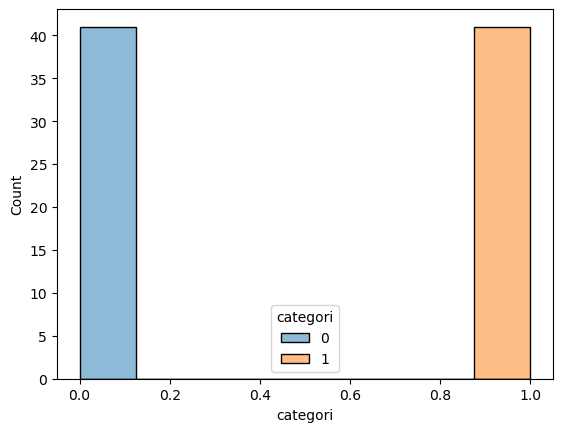

In [120]:
sns.histplot(train_set_rus, x = params['label'], hue = params['label'])

In [121]:
train_set_rus[params['label']].value_counts()

0    41
1    41
Name: categori, dtype: int64

Oversampling

In [122]:
ros = RandomOverSampler(random_state = 123)

In [123]:
X_ros, y_ros = ros.fit_resample(train_set.drop(params['label'], axis = 1), train_set[params['label']])

In [124]:
train_set_ros = pd.concat([X_ros, y_ros], axis = 1)

<AxesSubplot:xlabel='categori', ylabel='Count'>

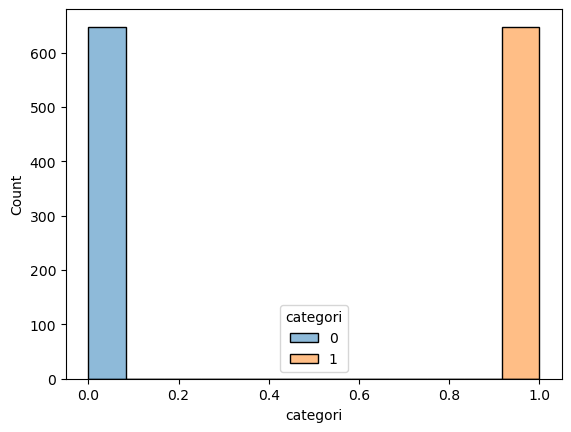

In [125]:
sns.histplot(train_set_ros, x = params['label'], hue = params['label'])

In [126]:
train_set_ros[params['label']].value_counts()

0    648
1    648
Name: categori, dtype: int64

SMOTE

In [127]:
sm = SMOTE(random_state = 123)

In [128]:
X_sm, y_sm = sm.fit_resample(train_set.drop(params['label'], axis = 1), train_set[params['label']])

In [129]:
train_set_sm = pd.concat([X_sm, y_sm], axis = 1)

<AxesSubplot:xlabel='categori', ylabel='Count'>

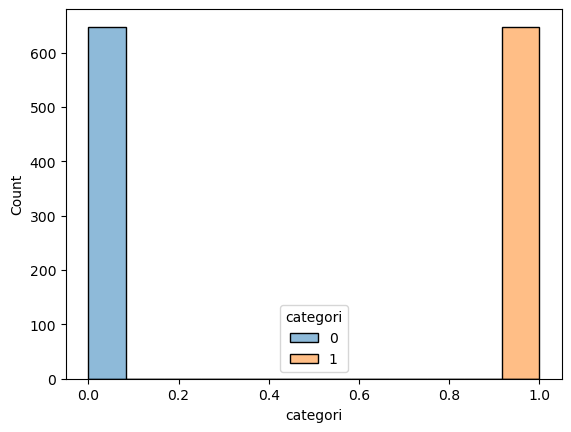

In [130]:
sns.histplot(train_set_sm, x = params['label'], hue = params['label'])

In [131]:
train_set_sm[params['label']].value_counts()

0    648
1    648
Name: categori, dtype: int64

# Feature Selection

Kendall's rank

In [132]:
# Input output split
X_train_set, y_train_set = input_output_split(df = train_set, column = params['label'])

In [133]:
# cat num split
X_train_cat, X_train_num, X_train_OHE = num_cat_split(X_train_set, params['range_stasiun'])

In [134]:
# Show Kendall's rank coefficient and p-value
kendall_rank(input = X_train_num, output = y_train_set)

{'pm10': (-0.32534019336378767, 5.714175574392051e-25),
 'pm25': (-0.32781799967805947, 1.3675662452688476e-25),
 'so2': (-0.14375662949466622, 5.565420724704569e-06),
 'co': (-0.24077415273630728, 8.341768138014866e-14),
 'o3': (-0.10664815573269286, 0.0007290076140834427),
 'no2': (-0.26351799849686386, 8.568258551507013e-17)}

Chi square test

In [135]:
# Create contingency table and chi-square calculation function
def chi_square_test(input, output):
    
    """
    This function is created to calculate the level of significance between object type input data and object type 
    output data using chi-squared test
    
    :param input: <pandas dataframe> data contain input
    :param output: <pandas dataframe> data contain output
    :return contingency_tables: <dictionary> collection of distribution of a set of categorical variables
    :return p_values_chi2: <dictionary> collection of p-value
    """
    
    # Create an empty dictionary to store the contingency tables
    contingency_tables = {}
    
    # Loop over each column in the boolean or categorical DataFrame
    for col in input.columns:
        
        # Create the contingency table
        contingency_table = pd.crosstab(output, input[col])
        
        # Store the contingency table in the dictionary
        contingency_tables[col] = contingency_table
        
    # Print the contingency tables
    for col, contingency_table in contingency_tables.items():
        print(f"{col}:")
        print(contingency_table)

    print("----------")    
        
    # Create an empty dictionary to store the p-values
    p_values_chi2 = {}
    
    # Loop over each contingency table
    for col, contingency_table in contingency_tables.items():
        
        # Calculate the chi-squared test statistic and p-value
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Store the p-value in the dictionary
        p_values_chi2[col] = p
        
    # Print the p-values
    for col, p in p_values_chi2.items():
        print(f"{col}: {p:.7f}")

In [136]:
# Show contingency table and p_value
chi_square_test(input = X_train_cat, output = y_train_set)

DKI1 (Bunderan HI):
DKI1 (Bunderan HI)    0    1
categori                    
0                   521  127
1                    29   12
DKI2 (Kelapa Gading):
DKI2 (Kelapa Gading)    0    1
categori                      
0                     520  128
1                      33    8
DKI3 (Jagakarsa):
DKI3 (Jagakarsa)    0    1
categori                  
0                 519  129
1                  33    8
DKI4 (Lubang Buaya):
DKI4 (Lubang Buaya)    0    1
categori                     
0                    517  131
1                     38    3
DKI5 (Kebon Jeruk) Jakarta Barat:
DKI5 (Kebon Jeruk) Jakarta Barat    0    1
categori                                  
0                                 515  133
1                                  31   10
----------
DKI1 (Bunderan HI): 0.1951103
DKI2 (Kelapa Gading): 1.0000000
DKI3 (Jagakarsa): 1.0000000
DKI4 (Lubang Buaya): 0.0687188
DKI5 (Kebon Jeruk) Jakarta Barat: 0.6940681


In [137]:
# Probability of each station
for col in params['range_stasiun']:
    prob = X_train_set[col].sum() / len(X_train_set)
    print(f"{col} = {prob}")

DKI1 (Bunderan HI) = 0.20174165457184326
DKI2 (Kelapa Gading) = 0.19738751814223512
DKI3 (Jagakarsa) = 0.1988388969521045
DKI4 (Lubang Buaya) = 0.19448476052249636
DKI5 (Kebon Jeruk) Jakarta Barat = 0.20754716981132076


There is no correlation between station and categori (with evidence of probability and p-value). Therefore, this study will try to find correlation on the subset (per station)

In [138]:
# Split to subset
train_set_1 = train_set[train_set[params['range_stasiun'][0]] != 0]
train_set_2 = train_set[train_set[params['range_stasiun'][1]] != 0]
train_set_3 = train_set[train_set[params['range_stasiun'][2]] != 0]
train_set_4 = train_set[train_set[params['range_stasiun'][3]] != 0]
train_set_5 = train_set[train_set[params['range_stasiun'][4]] != 0]

In [139]:
# Sanity check
print(train_set_1.shape, train_set_2.shape, train_set_3.shape, train_set_4.shape, train_set_5.shape)

(139, 12) (136, 12) (137, 12) (134, 12) (143, 12)


In [140]:
# Input output split
X_train_set_1, y_train_set_1 = input_output_split(df = train_set_1, column = params['label'])
X_train_set_2, y_train_set_2 = input_output_split(df = train_set_2, column = params['label'])
X_train_set_3, y_train_set_3 = input_output_split(df = train_set_3, column = params['label'])
X_train_set_4, y_train_set_4 = input_output_split(df = train_set_4, column = params['label'])
X_train_set_5, y_train_set_5 = input_output_split(df = train_set_5, column = params['label'])

In [141]:
# cat num split
X_train_cat_1, X_train_num_1, X_train_OHE_1 = num_cat_split(X_train_set_1, params['range_stasiun'])
X_train_cat_2, X_train_num_2, X_train_OHE_2 = num_cat_split(X_train_set_2, params['range_stasiun'])
X_train_cat_3, X_train_num_3, X_train_OHE_3 = num_cat_split(X_train_set_3, params['range_stasiun'])
X_train_cat_4, X_train_num_4, X_train_OHE_4 = num_cat_split(X_train_set_4, params['range_stasiun'])
X_train_cat_5, X_train_num_5, X_train_OHE_5 = num_cat_split(X_train_set_5, params['range_stasiun'])

In [142]:
# Show Kendall's rank coefficient and p-value
kendall_rank(input = X_train_num_1, output = y_train_set_1)

{'pm10': (-0.4025057527312432, 1.3002197561783117e-08),
 'pm25': (-0.40083966897087514, 1.2129257028866782e-08),
 'so2': (0.10469919307942581, 0.1453854447425431),
 'co': (-0.3094470816151512, 1.755552011834772e-05),
 'o3': (-0.265294519889513, 0.00019712116809485832),
 'no2': (-0.37700746685530484, 9.508454637837417e-08)}

In [143]:
# Show Kendall's rank coefficient and p-value
kendall_rank(input = X_train_num_2, output = y_train_set_2)

{'pm10': (-0.3212402195099181, 6.458723143889684e-06),
 'pm25': (-0.3364880934940289, 2.1729497610044198e-06),
 'so2': (-0.30421495934829273, 2.496959623032551e-05),
 'co': (-0.2727334252797733, 0.00022290435958134875),
 'o3': (-0.1482900700849267, 0.03774318261969487),
 'no2': (-0.20138117626901295, 0.005088077476989224)}

In [144]:
# Show Kendall's rank coefficient and p-value
kendall_rank(input = X_train_num_3, output = y_train_set_3)

{'pm10': (-0.2869428654296746, 5.416001047233396e-05),
 'pm25': (-0.294452461171451, 3.1302725637842985e-05),
 'so2': (-0.1749345475721581, 0.01616733988847593),
 'co': (-0.1682166247309214, 0.02052117021748047),
 'o3': (0.03299443917669568, 0.6456971746338108),
 'no2': (-0.20054345380946098, 0.0058436639989615175)}

In [145]:
# Show Kendall's rank coefficient and p-value
kendall_rank(input = X_train_num_4, output = y_train_set_4)

{'pm10': (-0.2117975088285261, 0.0032546371436074795),
 'pm25': (-0.21135099481614691, 0.0031175108672005193),
 'so2': (-0.0626387336094909, 0.3972691706657486),
 'co': (-0.16063619136436086, 0.0291070903749937),
 'o3': (-0.06416305904564472, 0.3743941784244115),
 'no2': (-0.17680943473850583, 0.015506375768125373)}

In [146]:
# Show Kendall's rank coefficient and p-value
kendall_rank(input = X_train_num_5, output = y_train_set_5)

{'pm10': (-0.36436159911828625, 1.6757495203252932e-07),
 'pm25': (-0.3644002468935802, 1.4009480808586985e-07),
 'so2': (-0.19033272928838949, 0.00862065141007356),
 'co': (-0.36432627389986605, 2.6197803145280886e-07),
 'o3': (-0.2532133354513332, 0.0002975798018591553),
 'no2': (-0.31175832058160613, 7.373415860365638e-06)}

The predictor variable in each station mostly have significant correlation when being compared to categori column. Therefore, no feature will be removed.

# Modeling

In [147]:
# Import library
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

Create a baseline performance

In [148]:
# Create a baseline model
y_train_set.value_counts(normalize = True)

0    0.940493
1    0.059507
Name: categori, dtype: float64

Prepare the dataset being used for modeling:

- X_rus, y_rus (done)
- X_ros, y_ros (done)
- X_sm, y_sm (done)
- X_valid, y_valid
- X_test, y_test

In [149]:
# Input output split
X_valid, y_valid = input_output_split(df = validation_set, column = params['label'])
X_test, y_test = input_output_split(df = testing_set, column = params['label'])

In [150]:
# Sanity check
print(X_rus.shape, X_ros.shape, X_sm.shape, X_valid.shape, X_test.shape)

(82, 11) (1296, 11) (1296, 11) (186, 11) (186, 11)


Create log template

In [151]:
# Create time stamp for current date and time
def time_stamp():
    return datetime.now()

In [152]:
# Create log template
def create_log_template():
    
    """
    This function is to create a log template to store the training log.
    
    :return logger: <dictionary> an empty log template
    """
    
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [153]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()
    
    """
    This function updates the training log file with the current log data.

    :param current_log: <dictionary> dictionary containing the current training log data
    :param log_path: <str> path to the training log file
    :return last_log: <list> updated training log
    """

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

In [154]:
# Create model object
lgr_baseline = LogisticRegression()
dct_baseline = DecisionTreeClassifier()
rfc_baseline = RandomForestClassifier()
knn_baseline = KNeighborsClassifier()
xgb_baseline = XGBClassifier()

In [155]:
# Create dictionary
list_of_model = {
    "normal" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "undersampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    }

In [156]:
def train_eval_model(list_of_model, prefix_model_name, X_train, y_train, data_configuration_name, X_valid, y_valid, log_path):

    """
    This function trains and evaluates a list of machine learning models, logs their performance, 
    and returns the updated training log and list of models.

    :param list_of_model: <list> list of dictionaries containing model name, model object, and other information
    :param prefix_model_name: <str> prefix to be added to the model name
    :param X_train: <pandas DataFrame> training dataset features
    :param y_train: <pandas DataFrame> training dataset labels
    :param data_configuration_name: <str> name of the data configuration used for training
    :param X_valid: <pandas DataFrame> validation dataset features
    :param y_valid: <pandas DataFrame> validation dataset labels
    :param log_path: <str> path to the training log file
    :return training_log: <list> updated training log
    :return list_of_model: <list> list of trained models
    """
    
    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        start_time = time_stamp()
        model["model_object"].fit(X_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model["model_object"].predict(X_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

1. Normal

In [157]:
# Checking performance using different model on a normal condition
training_log, list_of_model_nor = train_eval_model(list_of_model["normal"], 
                                                   "baseline_model",
                                                   X_train_set,
                                                   y_train_set,
                                                   "normal",
                                                   X_valid,
                                                   y_valid,
                                                   "log/training_log.json")

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 60%|██████    | 3/5 [00:00<00:00, 24.67it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the v

In [158]:
# Update list of model
list_of_model["normal"] = copy.deepcopy(list_of_model_nor)

2. Undersampling

In [159]:
# Checking performance using different model after undersampling
training_log, list_of_model_rus = train_eval_model(list_of_model["undersampling"], 
                                                   "baseline_model",
                                                   X_rus,
                                                   y_rus,
                                                   "undersampling",
                                                   X_valid,
                                                   y_valid,
                                                   "log/training_log.json")

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 60%|██████    | 3/5 [00:00<00:00, 24.49it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the v

In [160]:
# Update list of model
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

3. Oversampling

In [161]:
# Checking performance using different model after oversampling
training_log, list_of_model_ros = train_eval_model(list_of_model["oversampling"], 
                                                   "baseline_model",
                                                   X_ros,
                                                   y_ros,
                                                   "oversampling",
                                                   X_valid,
                                                   y_valid,
                                                   "log/training_log.json")

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 60%|██████    | 3/5 [00:00<00:00, 19.29it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the v

In [162]:
# Update list of model
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

4. SMOTE

In [163]:
# Checking performance using different model after SMOTE
training_log, list_of_model_sm = train_eval_model(list_of_model["smote"], 
                                                  "baseline_model",
                                                  X_sm,
                                                  y_sm,
                                                  "smote",
                                                  X_valid,
                                                  y_valid,
                                                  "log/training_log.json")

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 60%|██████    | 3/5 [00:00<00:00, 16.76it/s]C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the v

In [164]:
# Update list of model
list_of_model["smote"] = copy.deepcopy(list_of_model_sm)

5. Best performance

In [165]:
def training_log_to_df(training_log):
    
    """
    This function takes in the training log and returns a pandas dataframe containing
    all training logs sorted based on f1-score and training time.

    :param training_log: <list> list of training logs
    :return training_res: <pandas dataframe> dataframe containing training logs
    """
    
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

In [166]:
# Store training log to dataframe
training_res = training_log_to_df(training_log)

100%|██████████| 4/4 [00:00<00:00, 666.95it/s]


In [167]:
# Show dataframe
training_res

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-DecisionTreeClassifier,796e8ddbfeeee9b7238b016fde92d534,0.002000,2023-04-20 00:21:48.848746,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
1,baseline_model-DecisionTreeClassifier,caccc6f0cfe998f1f8044725d879a8c3,0.003000,2023-04-20 00:21:49.105286,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
2,baseline_model-XGBClassifier,d9c7fcb15be99f39eafd22a48145585f,0.032507,2023-04-20 00:21:48.981260,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
3,baseline_model-XGBClassifier,9c75990bae8d8462379b13d93c985208,0.032513,2023-04-20 00:21:49.259807,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
4,baseline_model-XGBClassifier,82eb881e4a2d3cd75a7ccd7d3d4b56bd,0.052997,2023-04-20 00:21:48.493213,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,normal
5,baseline_model-DecisionTreeClassifier,833672422b452f71f624050ecffed76b,0.001998,2023-04-20 00:21:48.387120,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,normal
6,baseline_model-LogisticRegression,60e82b3d635c8eec0154c0bcd6307a97,0.021507,2023-04-20 00:21:48.360611,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,normal
7,baseline_model-RandomForestClassifier,f9bfd2c2bc035c6150a214894ecd5b52,0.081004,2023-04-20 00:21:48.392119,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,normal
8,baseline_model-RandomForestClassifier,3c82fa3c6eac58ffd8902b5658660291,0.105510,2023-04-20 00:21:48.853746,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,oversampling
9,baseline_model-RandomForestClassifier,f50c03fd5328ae91856a4b0223ec6df9,0.125522,2023-04-20 00:21:49.112286,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,smote


In [168]:
def get_best_model(training_log_df, list_of_model):

    """
    This function takes in the training log dataframe and list of model objects and
    returns the best model object based on f1-score and training time.
    
    :param training_log_df: <pandas dataframe> dataframe containing training logs
    :param list_of_model: <dict> dictionary containing list of model objects for each data configuration
    :return model_object: <object> the best performing model object
    :raise RuntimeError: If the best model is not found in the list of model objects
    """
    
    model_object = None

    best_model_info = training_log_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object

In [169]:
# Get the best model object
model = get_best_model(training_res, list_of_model)

In [170]:
# Show best model
model

DecisionTreeClassifier()

Based on the above, the training finds that K-Nearest Neighbour's performance did not contain within the top 10 of training, therefore hyperparameter tuning may need to be performed.

In [171]:
dist_params_knn = {
    "algorithm" : ["ball_tree", "kd_tree", "brute"],
    "n_neighbors" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
    "leaf_size" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
}

In [172]:
knn_enhance = GridSearchCV(KNeighborsClassifier(), dist_params_knn, n_jobs = -1, verbose = 420, cv = 5)

In [173]:
list_of_model["normal"].append({"model_name": knn_enhance.__class__.__name__ + "-" + knn_enhance.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enhance), "model_uid": ""})
list_of_model["undersampling"].append({"model_name": knn_enhance.__class__.__name__ + "-" + knn_enhance.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enhance), "model_uid": ""})
list_of_model["oversampling"].append({"model_name": knn_enhance.__class__.__name__ + "-" + knn_enhance.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enhance), "model_uid": ""})
list_of_model["smote"].append({"model_name": knn_enhance.__class__.__name__ + "-" + knn_enhance.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enhance), "model_uid": ""})

1. Normal

In [174]:
training_log, list_of_model_nor_enhanced = train_eval_model([list_of_model["normal"][-1]],
                                                            "hyperparams",
                                                            X_train_set,
                                                            y_train_set,
                                                            "normal",
                                                            X_valid,
                                                            y_valid,
                                                            "log/training_log.json")

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


In [175]:
list_of_model["normal"][-1] = copy.deepcopy(list_of_model_nor_enhanced[0])

2. Undersampling

In [176]:
training_log, list_of_model_rus_enhanced = train_eval_model([list_of_model["undersampling"][-1]],
                                                            "hyperparams",
                                                            X_rus,
                                                            y_rus,
                                                            "undersampling",
                                                            X_valid,
                                                            y_valid,
                                                            "log/training_log.json")

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


In [177]:
list_of_model["undersampling"][-1] = copy.deepcopy(list_of_model_rus_enhanced[0])

3. Oversampling

In [178]:
training_log, list_of_model_ros_enhanced = train_eval_model([list_of_model["oversampling"][-1]],
                                                            "hyperparams",
                                                            X_ros,
                                                            y_ros,
                                                            "oversampling",
                                                            X_valid,
                                                            y_valid,
                                                            "log/training_log.json")

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


In [179]:
list_of_model["oversampling"][-1] = copy.deepcopy(list_of_model_ros_enhanced[0])

4. SMOTE

In [180]:
training_log, list_of_model_sm_enhanced = train_eval_model([list_of_model["smote"][-1]],
                                                           "hyperparams",
                                                           X_sm,
                                                           y_sm,
                                                           "smote",
                                                           X_valid,
                                                           y_valid,
                                                           "log/training_log.json")

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\62821\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


In [181]:
list_of_model["smote"][-1] = copy.deepcopy(list_of_model_sm_enhanced[0])

In [182]:
training_log_to_df(training_log)

100%|██████████| 8/8 [00:00<00:00, 888.98it/s]


,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-DecisionTreeClassifier,796e8ddbfeeee9b7238b016fde92d534,0.002000,2023-04-20 00:21:48.848746,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
1,baseline_model-DecisionTreeClassifier,caccc6f0cfe998f1f8044725d879a8c3,0.003000,2023-04-20 00:21:49.105286,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
2,baseline_model-XGBClassifier,d9c7fcb15be99f39eafd22a48145585f,0.032507,2023-04-20 00:21:48.981260,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
3,baseline_model-XGBClassifier,9c75990bae8d8462379b13d93c985208,0.032513,2023-04-20 00:21:49.259807,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
4,baseline_model-XGBClassifier,82eb881e4a2d3cd75a7ccd7d3d4b56bd,0.052997,2023-04-20 00:21:48.493213,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,normal
5,baseline_model-DecisionTreeClassifier,833672422b452f71f624050ecffed76b,0.001998,2023-04-20 00:21:48.387120,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,normal
6,baseline_model-LogisticRegression,60e82b3d635c8eec0154c0bcd6307a97,0.021507,2023-04-20 00:21:48.360611,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,normal
7,baseline_model-RandomForestClassifier,f9bfd2c2bc035c6150a214894ecd5b52,0.081004,2023-04-20 00:21:48.392119,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,normal
8,baseline_model-RandomForestClassifier,3c82fa3c6eac58ffd8902b5658660291,0.105510,2023-04-20 00:21:48.853746,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,oversampling
9,baseline_model-RandomForestClassifier,f50c03fd5328ae91856a4b0223ec6df9,0.125522,2023-04-20 00:21:49.112286,"{'0': {'precision': 0.9943181818181818, 'recal...",0.974766,smote


Turns out after hyperparameter tuning, the K-Nearest Neighbour's performance still did not contain within the top 10. Therefore, we proceed with RandomForestClassifier as the best model.

**Validation set**

In [183]:
# Prediction using input
y_pred_valid = model.predict(X_valid)

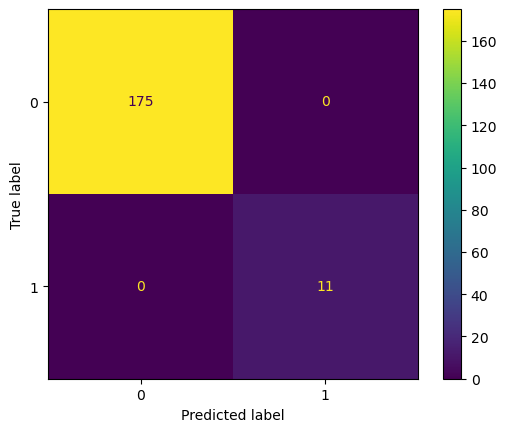

In [184]:
# Show confusion matrix
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_valid)

In [185]:
# Show classification report
print(classification_report(y_true = y_valid,
                            y_pred = y_pred_valid,
                            target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       175
           1       1.00      1.00      1.00        11

    accuracy                           1.00       186
   macro avg       1.00      1.00      1.00       186
weighted avg       1.00      1.00      1.00       186



**Test set**

In [186]:
# Prediction using input
y_pred_test = model.predict(X_test)

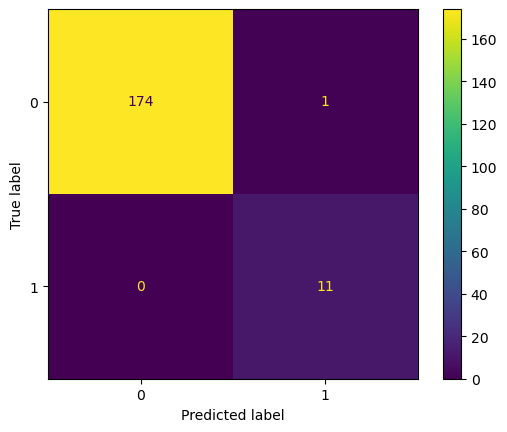

In [187]:
# Show confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

In [188]:
# Show classification report
print(classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       175
           1       0.92      1.00      0.96        11

    accuracy                           0.99       186
   macro avg       0.96      1.00      0.98       186
weighted avg       1.00      0.99      0.99       186



By comparing validation and test set, the performance of test set does not fall significantly from the validation set. Therefore, the leakage may not happen within the dataset.